In [29]:
import pandas as pd #'version 1.2.4'
import numpy as np #'version 1.21.0'
from basico import * #'version 0.36'
from scipy.optimize import minimize #'version 1.10.0'
import random
import matplotlib.pyplot as plt #'version 3.3.4'


path = !pwd
path = path[0]

In [30]:
# define the path for the models and the variant names then combine them
mod_path =path + "/Models/"
files =  ["NMGPL_Model_v2.xml", "NPMGL_Model_v2.xml", "NMPGL_Model_v2.xml", "NGPML_Model_v2.xml", "NGMPL_Model_v2.xml"] # ,"NMPGL_Model.xml", "NGMPL_Model.xml", "NGPML_Model.xml"]
models = [mod_path + m for m in files]

In [31]:
# load one of the models in and get reaction names
mod = load_model(models[0])
set_current_model(mod)
reactions  = np.array(get_reaction_parameters()["reaction"])


In [32]:
# load in models
models_loaded = []
for tmod in models:
    print(tmod)
    mod = basico.load_model(tmod)
    models_loaded.append(mod)

/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants_v2 - supplement 6 - in progress/Models/NMGPL_Model_v2.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants_v2 - supplement 6 - in progress/Models/NPMGL_Model_v2.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants_v2 - supplement 6 - in progress/Models/NMPGL_Model_v2.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants_v2 - supplement 6 - in progress/Models/NGPML_Model_v2.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants_v2 - supplement 6 - in progress/Models/NGMPL_Model_v2.xml


In [33]:
# remove transcription reactions from reactions to be fit
reacts_list = reactions[["transcription_" not in react for react in reactions]]

In [34]:
# get k values of the reactions to get their current fit values
basico.set_current_model(models_loaded[0])
ks = np.array(get_reaction_parameters()["value"])
ks = ks[[react in reacts_list for react in reactions]]

In [35]:
data = np.array([4347, 2087, 2348, 1304, 3957]) # observed mean virions produced by variants seen in literature

In [36]:
# define the function that will be parallelized 
def parallelization(ins):
    # import packages
    import basico
    from scipy.optimize import minimize
    import numpy as np
    # define the objective function
    def obj_func(x):
        preds = np.zeros(len(models_loaded))
        # iterate through the models
        for i, model in enumerate(models_loaded):
            basico.set_current_model(model)
            # change the reaction rates 
            for m, param_name in enumerate(reacts_list):
                basico.set_reaction(param_name, mapping={"k1": x[m]})
            # simulate the model. If an error occurs set the prediction value to infinity
            try:
                tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
                preds[i] = tc["V"].loc[57000]
            except:
                preds[i] = np.inf
        # calculate and return the MSE
        test = np.mean((preds - data)**2)
        print(test)
        del m, preds, tc
        return test
    # unpack the inputs of the parallelization function
    guess, models,  data, path, reacts_list, tolerance = ins
    models_loaded = []
    # load models in
    for tmod in models:
        mod = basico.load_model(tmod)
        models_loaded.append(mod) 
    lowest = np.Inf
    del tmod
    # fit the model
    res = minimize(obj_func, guess, method = 'Nelder-Mead', tol = tolerance, bounds =[[10e-20,np.Inf]] * len(guess),options = {"maxiter" : 1000}) # perform optimization
    del models_loaded
    
    del guess, models,  data, path, reacts_list
    # return the results of fitting
    return res


In [41]:
# keep fitting the model until the objective function is less than 100000
obj_func_val = 360000
while obj_func_val > 100000:
    res = parallelization([ks, models, data, path, reacts_list, .1])
    ks = res.x
    obj_func_val = res.fun


279927.5593298601
279988.3750434177
279920.54997835733
279931.49751130305
282734.2486847779
279930.0067149002
281324.1216491711
279927.6154620217
279625.94133572385
286621.78521914815
279924.88879988383
740115.6827098663
279927.2940417808
291148.7138737627
279928.1658986301
286767.2172040306
279927.78237265354
279922.0803548649
289168.31623970706
279927.6492663633
279926.55336062703
279924.0773325356
279927.55910693546
336504.5170344544
281187.51827234076
280651.2763575943
287327.88283926714
279928.85608626634
279926.91495505866
287695.880765346
279926.59195353335
279463.6452323069
279927.5583492159
279927.24486346805
279917.7328427335
279928.652101696
279963.5799683612
719575.9800003741
407327.07960141124
390861.08581662085
308916.42932955344
338059.13784363144
295203.6451991489
313964.6727413469
287987.19561900257
295698.76004512
284205.50515335146
285535.15637841413
309074.68587935803
283223.1276246436
288946.20617585216
282107.10408814077
287193.5417037796
283168.1977522967
287667.

274388.0652899168
274368.2052808254
274435.4298888562
274300.6032305331
274217.94633570063
273513.9661516702
274201.1774735912
274172.8556592868
274102.08314698923
274116.4032787359
274078.50578346674
274101.11112998903
273963.6049109501
274029.9911422129
273854.8745331845
273836.4312145968
273812.51065318653
273767.85611891974
273877.52723915485
273639.5980491942
273581.92253777623
273565.8294541748
273481.219699508
272765.37468045816
273412.61296836997
273343.6986324432
273298.4560366903
273260.66304171283
273284.55980807135
273340.4466973204
273177.50032602856
273103.2164179818
273050.959605308
273036.0955463013
273086.30140566203
272882.83624228503
272973.95513278095
272798.6505903766
272846.79011646693
272713.41377364227
271889.48167867877
272595.9900786192
272572.8178256895
272617.7325054874
272544.8181591471
272445.34866444825
272395.5040364185
272330.2595725913
272384.43044948566
272152.2656491657
272266.3141474733
272091.417032907
272193.97201092425
272059.31960940396
271930.4

250216.2372174585
251465.51100017276
251971.45711861976
254518.90640804902
253429.74893995342
251894.5134479634
253107.07107702567
251154.00271689837
255545.31763075627
253300.71363625186
252169.757666626
251123.6601956117
251278.19949278716
251140.60756538855
253033.57184139732
251334.69617857272
251724.612543853
250780.31755157118
250909.33158772337
251751.3526078149
252123.20297921897
250606.56156365448
251928.61850231825
250831.66269614437
250290.71355349888
250417.89372616052
250120.7732420451
248910.51828900864
249846.67608657488
250836.51675836658
250111.88023070627
250748.34732078185
249763.88391245715
250432.4733237407
249438.26679427
249300.34994110232
249235.85142620755
249416.31621656948
249249.4337087789
249134.03682388915
249380.8329435615
249017.85845260663
250043.42950694956
249065.48536390596
248740.52224172006
248259.60020115506
248276.52867154023
250564.3629834461
249153.29020068696
250258.92164369236
248976.92203292204
249188.08001233888
248651.2400382952
248064.835

217301.2570337464
217382.28032332557
216935.6866059163
217040.77147802088
216825.6781392251
216128.7804827001
216810.87928334446
216681.71998571669
217212.1256450797
218432.10334113863
217618.2165250929
216746.12235947256
217274.26661237082
216706.897893245
216629.46804710577
216819.23801616867
216854.1851733067
217283.68923308133
216688.31728091472
216898.2976598179
216668.58050158372
216590.74066073666
216796.4343903827
216457.0817569308
216657.2722318493
216507.95815347307
216507.64452116936
216116.79978245543
215421.56355427662
216035.56087583568
216455.32860998012
215892.8985561939
216093.18134696805
215712.1703363626
215646.44009915282
215663.560117485
215862.51612022967
215522.7356905931
215695.80924156954
215766.66952032578
216391.07068699552
216178.81883523575
215324.09348766104
214465.62088655168
215958.52797647248
215203.73417135252
215286.19843895143
215161.442177225
215502.39487675577
215885.52270592452
215392.21401104733
215791.9322187922
215007.66124716043
215284.5070544

182532.90010474768
179707.9723904254
176505.00798576564
178968.72997121542
176162.8316745338
179791.68927361775
181854.2923489322
178681.05242670563
176463.29183909335
176313.8359576815
180183.59079520623
174624.98391318196
171740.36875739862
175489.21581677362
174830.18102139776
175507.07850674953
175698.66011885653
178123.45417837435
175985.28191115748
173029.89562798486
176520.88090336023
176332.4879918023
180917.43379741866
177664.55395416432
174408.8196006177
173086.75397613645
175797.4927108699
175426.08293602002
175713.0905713009
181396.14928347897
176699.54027452884
176516.77402328097
172053.04868457754
173890.39321974965
180300.07925575314
176304.5566809921
171417.3359608961
168367.4844109689
170836.80078501356
178239.7101305422
174797.00641245293
175072.99729204836
172362.22805109806
182333.31544578788
175340.11084006788
171235.79269383143
170116.67978346115
175889.76493192711
172250.82523336803
175362.83857458804
171714.3752760085
175200.9606962627
170622.59792626154
170376.

126062.95282361894
127629.98103205304
126279.79264203183
127384.10937571913
128177.82923619225
126256.44269930656
125153.22551133423
126366.56275803005
124847.5911653247
124912.05725306175
124815.32335788393
125382.11397749635
125546.75949783041
126845.67766687018
125257.05781943402
126967.73666510297
127081.5279976868
123915.57986138244
123943.46311315257
125183.5755922726
124968.00119096339
127842.42060787934
124563.07144128755
125249.61406863709
125048.94991748003
127749.66214538968
125177.56469048897
127380.71645002319
125241.72252876617
124952.52865725153
126885.28250057851
124101.45274378506
127711.8142168445
125645.22082377269
127936.24934915922
125479.43479079513
127725.64798752824
125570.72289886643
125632.46707269843
126045.14852701881
124718.33193425523
123685.08460096351
124071.29425823495
126818.30330595365
126650.98112649386
127575.54062930278
125179.5095596615
124997.5812057141
124981.19359124429
124916.2391716409
126590.51569089173
125055.56713115056
124116.34923156913


119651.39469773155
120262.72757466222
120122.55327369661
120178.48361217049
120119.48604985859
120294.2039064673
120034.45945790922
119945.65547628995
120132.42672166633
119853.96355950911
119844.09419123836
119779.9345790279
120211.27530235464
119899.93155660937
120347.19963853573
120303.69973794564
119736.9331089227
120054.29476715671
119681.10640983807
120271.13996970588
119807.53006188103
119600.537642962
119148.13344710026
119732.93136012093
119608.52210022164
119986.10872712739
119476.66149406756
119493.17252038236
119498.50101591348
119356.07516228143
119606.88820448812
119421.31967401903
119426.88626234148
119347.33852635755
119488.56568357845
119216.38311964183
119163.92586279777
119844.37150581232
119850.6068113106
119211.6784760496
119552.45801851584
119061.49436105977
118607.57790728041
118950.89470608118
119385.77968253903
119120.43178509155
119003.85785733494
118877.76853075271
118775.80009317251
118965.58995118
118743.36115039061
119047.71932712938
118712.5912142529
1187

103292.88884619217
108615.92409789059
104781.67952908103
103397.95987989029
104375.86723115151
103896.95358909301
103093.5801740689
103849.35156158036
103081.62334149375
102780.42220089023
102810.56322097736
103104.22949734975
103342.00139537659
103669.9763803321
102891.58749077341
102536.30086765214
104477.5629017424
102825.76354638983
103128.87575925588
102799.99520564002
103787.4238004885
102827.36098697929
102345.77897553172
109480.61071986025
103636.80396185545
103260.61979673457
103081.68770241855
102386.21896480661
102699.01900439663
102169.7279589305
101354.48317436739
102557.62205988861
101828.5771117487
101795.944355439
102159.01032308949
101732.28550684491
101761.6127974247
102208.19997724483
102147.09983736
102141.91423667673
102546.04537551098
102094.82305384784
101418.42647340162
108271.06807026794
103028.41884800661
102596.84203076895
101174.962033288
99982.5322701142
101664.15675415636
101183.44932337034
101669.25367695275
101026.95308603584
101687.46919701267
102026.54

131186.3426389253
91643.38264604197
104721.69821556013
91595.49083070389
105283.20481617516
91566.58226045108
105587.24976945067
91525.95062940821
102066.41486488364
91481.95262901914
93374.87504958786
91392.77731608487
9224669.399795372
91544.69334719321
114807.0362020123
91409.6430899913
9224669.39979316
91452.03623416988
118320.51471588734
91336.67900904536
91463.27450015147
91962.46580925524
91189.7818946972
90009.21971358065
94724.9884744628
91071.6195231878
94787.69495115515
91034.82658075955
94712.32788991093
90979.14371440542
93802.65624523912
90934.26501388446
98311.2036471922
90917.89964889138
92813.31279696457
90870.27814577402
92812.88278229983
90837.05994132432
116931.74441196618
90871.11622269565
94256.09775960841
90785.47858542381
88685.53516276265
97508.01470286449
90701.86262383926
91714.15819241363
88377.91782544223
123963.08582306867
90734.64314295426
95616.2146219059
90639.18377189475
95434.00660686592
90585.43481275355
95169.03789901595
90563.33489436835
91432.9542

In [42]:
# Make dataframe contianing the results and save
functions_outputs = []
parameter_values = []
parameter_names = []

functions_outputs.append(res.fun)
parameter_values.append(res.x)
parameter_names.append(pars_to_fit)
df = pd.DataFrame([functions_outputs, parameter_values, reacts_list]).T
df.columns = ["obj function output", "parameter values", "parameter names"]

df.to_csv("vsv_fits_v2_100000_cutoff.csv")




In [45]:
# keep fitting the model until the objective function is less than 10000
obj_func_val = 100000
while obj_func_val > 10000:
    res = parallelization([ks, models, data, path, reacts_list, .1])
    ks = res.x
    obj_func_val = res.fun


87336.768346839
87302.77649993694
87312.8995653689
87338.70034472074
91281.88311344507
87336.79693687122
87948.776056761
87094.06762067259
86694.72120442448
91183.88893795523
87274.98022183558
266173.4649414192
87336.6630645711
94187.80367064445
87336.89567074324
104124.38174787961
87336.74635487984
87427.25656913314
104764.56354618366
87336.79084672031
87336.68013756053
87375.71722979899
87336.72888230105
90745.86908003417
87337.53641252141
87538.1418589848
87662.9824622063
87339.77103865668
87336.20114280912
87067.80833512792
87336.68737024916
87597.29470334333
87336.74079579937
87336.72575316926
87439.33590807412
87337.01388385084
87332.92500256488
210657.34308068771
115352.38734423232
134112.18668516265
92365.01813258528
102293.70882903496
100841.23562808064
103772.9841474819
90584.10430154376
104285.74388314305
90020.8167222575
99923.44878210132
88367.19139237008
97613.12077763914
87704.15400252247
88607.54140580315
95581.5251269003
87612.25283422077
95363.06244320466
87371.729485

62164.264344154835
60629.38511451464
58270.66530478463
64440.13196553812
57792.09816250023
53602.29046830704
57206.48708960043
69419.40083650181
63809.501810539805
66693.98427340078
57732.68005387242
58456.33535674701
61373.50966781046
65860.10385001128
65456.397432208505
60136.79199099217
69520.88771101022
62747.87098302506
65402.245015277214
55525.50131864182
75760.95138992296
62063.12047013695
63985.21102405964
65725.43469057462
58829.28701187938
57244.738872539674
59627.34176513737
57821.97140359842
57073.44247040331
61294.69815778633
57539.67612691947
61077.08967603559
60662.331917691125
56506.1984402725
58441.427482171355
62701.87309176545
56152.15025100046
64596.34780176062
59998.12972127282
55602.407856253
58773.486369044695
61540.39306718072
56420.347444927764
56145.69011552527
57956.04619838179
58407.001968615084
54092.64775613325
64109.87174871958
58640.38432994272
59785.860594481324
57978.048185540465
68293.1946987935
58104.850405312165
59169.31212087495
60236.53396589322
5

42062.73955127003
42376.34125572133
42891.618066015704
41231.42670313123
40392.363269985166
42051.70123952018
42126.13259419543
42099.267871900054
40987.26005387147
41498.9112168209
42040.912759365725
41659.868762576225
42425.361251649694
42373.9418617424
41854.36918069054
42355.54531253801
41772.07669773217
41609.433294887065
41031.597628066724
41302.41254774451
40714.08015720214
41056.74125148637
41282.970115606935
41627.35020666053
41093.93791793513
41025.30624403326
40540.81105468257
42046.508432520954
41549.64129579619
41146.06746442639
42013.693475059976
41537.3113731137
40261.86258377416
39404.252965982516
40761.425259561445
41125.11442788969
40970.180532211176
41552.78660590952
40276.6306893726
40518.62771106459
40337.63601603842
40454.52955619499
40959.00589475684
41865.50068196658
41119.8913798275
41160.61358309198
39807.50446624377
40082.651921858574
41705.23818871783
40532.38201544156
39800.56937296972
40282.15730670107
41575.99659089803
39887.03950586355
39581.020547211265

23033.486387366615
22999.676625545435
22367.661595074584
22365.807400455487
22841.982864067035
23319.63021289421
23905.94428272961
22396.188953582554
23976.657617411718
22934.266912219402
22236.62828028608
22360.821692137495
21713.421559102328
20885.36173045217
23395.892263659967
22311.553848867887
22851.448540944177
21859.590285930048
22238.96621853846
21874.511832867753
22110.986325940998
22476.804618085578
21749.07184854407
23107.050633387527
21966.599153492487
23035.22545458617
22264.462460340783
21997.116399173952
22100.817485093467
23259.163600791006
22409.258406058892
22251.80675642606
23374.005101544775
22293.67886421031
24271.262254688947
22339.70424434394
21567.956752976366
21563.271991530048
21680.995423019405
21821.8681968307
21870.871377929627
21510.7886975938
22823.199025934868
22136.881457087155
22642.98746940305
21366.051244945396
21427.461133939614
21322.24531552858
22474.418267186145
21117.45748557006
21090.65069271942
21048.53755772629
20908.0864541688
22285.15446598

9417.63822974388
9385.301677374639
9285.170647947305
9440.0647556871
9733.556320208329
9389.913808241174
9577.401207917412
9162.046136616296
9239.810443639593
9596.851777683
9390.246564110223
9560.213347871999
9237.366126453464
9207.370843905368
9466.879146424839
9554.89590208437
9556.509001705415
9700.686782907713
9335.257011172976
9313.728782832322
9438.345659760033
9509.08102922847
9363.063574124688
9555.209988398949
9340.738336636901
9550.168952124986
9554.522987177128
9348.588636562681
9551.38186731622
9334.817601308398
9551.487004293083
9325.805810667158
9405.448077916999
9180.421810137068
9280.00227628202
9734.706003366007
9281.388326203358
9410.066091855566
9419.388956717807
9278.015541014816
9206.07636986205
9301.878128348246
9171.64657811732
9283.87761172793
9257.165742537489
9305.411856071702
9299.780601070188
9145.427728229755
9383.183454658152
9406.617840220806
9132.758883390281
9305.57097439902
9351.805405033967
9130.166043245843
9357.980968414438
9360.994120206891
9411.3

8359.078918845435
8310.583049632958
8330.558857936034
8265.581206643752
8196.224405259007
8352.946127890353
8271.13570101402
8302.62984954163
8311.34180350359
8333.371911984967
8237.416306301995
8330.010793893907
8211.022429544282
8266.388220102399
8259.387414946877
8281.716741298744
8219.932451501434
8277.986788728394
8201.708495885383
8203.670588773146
8264.77199175813
8181.900805302347
8112.618886107902
8201.267844245001
8317.087307396461
8195.868057582275
8153.918785578532
8192.824341334283
8140.027528725381
8205.38398096243
8193.752215975503
8193.682020557038
8221.58125603361
8150.196100046914
8180.092464621865
8156.86660530994
8190.337184555098
8197.086518920747
8250.454659184801
8101.16355762545
8035.436722458915
8111.010548401374
8204.568091551624
8157.969995012221
8125.513030278879
8125.649639656195
8075.209144691975
8094.785278352875
8109.0758014424255
8070.563517408011
8167.606986723282
8034.116395613646
7955.208812052416
8089.506215463121
8063.4161665462425
8048.96443290819

In [46]:
# Make dataframe contianing the results and save

functions_outputs = []
parameter_values = []
parameter_names = []

functions_outputs.append(res.fun)
parameter_values.append(res.x)
parameter_names.append(pars_to_fit)




df = pd.DataFrame([functions_outputs, parameter_values, reacts_list]).T
df.columns = ["obj function output", "parameter values", "parameter names"]
df.to_csv("vsv_fits_v2_10000_cutoff.csv")

In [48]:
# keep fitting the model until the objective function is less than 6000
obj_func_val = 10000
while obj_func_val > 6000:
    res = parallelization([ks, models, data, path, reacts_list, .1])
    ks = res.x
    obj_func_val = res.fun


7606.700314977313
7599.389838570479
7601.637873619557
7607.150789641906
14950.575215473864
7606.81843268144
7768.590735335305
9075.786865462269
7722.033915620489
12062.463136616536
7734.171804190938
497909.01663471217
7606.661223325286
13024.938226276176
7606.468518230664
24678.845332879097
7606.54182198968
7596.871368076298
16714.308909552044
7606.590155539363
7606.125722645319
74959.27161700538
7606.537957426486
24663.087543232887
7606.711648538289
13776.193460621736
8557.669635049471
7604.264160729543
7606.358209390858
7590.71506732279
7606.61637499934
7591.507090787655
7606.714984738607
7606.647822565748
7619.603770948806
7606.57932330097
7605.383938648217
335555.12974405213
100364.66683766533
116080.75604755804
32841.05639126992
31714.62592500487
39493.00795381869
13530.25585104134
72968.85764076016
16987.085979295916
61235.7304524334
13261.087302307122
28503.556973906652
11721.957646672663
23729.178809105906
10316.13800073855
25718.894410030938
10481.379667335921
16487.7272954500

7327.098686081289
7329.708664334006
7322.618852795009
7314.404603077373
7322.208686664175
7327.515845101315
7327.545334272215
7321.969646935266
7323.648516097788
7317.301204484464
7323.505667412956
7335.949931841683
7322.16811257716
7318.445085313167
7330.912122686421
7312.103802296902
7302.766877906948
7308.295746593411
7310.663255606121
7329.3300352127435
7307.880787685191
7306.038988144503
7319.308892047712
7304.890876636852
7324.482754196831
7312.720534569999
7308.5841673302475
7299.168646574758
7289.0672934885715
7291.731964395064
7310.471799545165
7291.433478331875
7304.293653408196
7296.101112061335
7306.590876431971
7290.995291076523
7288.938353459275
7276.258979402813
7288.190294677142
7307.807257056072
7288.36717172204
7296.1752404619165
7316.689253988576
7298.661951038511
7296.505802178258
7290.898163097978
7296.5214303988005
7291.920845219138
7284.832184614692
7284.39831669095
7281.760218122295
7273.8419212635245
7260.2348090323985
7273.223000012117
7274.265782506283
7272.6

6868.9506950815
6828.829348321068
6866.421608538656
6833.4182927767615
6871.338962363232
6819.731085856758
6829.76465044221
6882.264259912056
6825.217899926235
6822.630954801489
6818.467115174515
6836.084266659341
6829.640116515795
6974.510878213681
6815.0439891870465
6853.234567602743
6822.512492708147
6869.3132617989395
6820.053544072762
6847.594355804254
6810.562682839816
6797.445805795685
6853.000081041358
6808.7507611245555
6886.127881461378
6809.632277754754
6841.240738424184
6808.9180911036865
6830.2627013982155
6804.210525107255
6827.46448215526
6832.97943288796
6805.648488068296
6827.699690174549
6821.6079842312265
6818.01176792602
6832.606634297505
6806.926519662232
6823.3742619904715
6813.153296954253
6841.611700309804
6809.771072536247
6782.776749373949
6825.9599294532545
6803.582332554703
6820.062054813467
6815.653260179368
6824.9761234387115
6802.785195253161
6797.216608985975
6826.192681863577
6802.7227666205745
6830.225493397107
6801.1761062377145
6809.475214135693
6786

6902.796795784692
6750.83242815063
6790.88208103302
6859.802829398778
6719.7187217186565
6804.912379549794
6733.366366754369
6784.014444214743
6826.472704333844
6713.085013902368
6798.40593547195
6711.786319769131
6769.951110380908
6811.370761022112
6711.144362525008
6838.668711129302
6707.369719948636
6787.056566930112
6711.899212312113
6811.137385750611
6708.581045406046
6860.9919172213995
6703.1900094486045
6802.398163166448
6707.024370982193
6746.170054203278
6707.715162933654
6785.668895501146
6699.108771963573
6793.9836885743325
6700.669827851338
6731.742099306592
6703.17973422684
6700.783040038715
6744.825985874854
6699.296028918769
6700.137414481399
6696.86986573632
6698.179124831741
6732.4596700347565
6698.879953907245
6698.276872327389
6722.750545597252
6698.052122030183
6699.249403334512
6701.654674555037
6703.520836471561
6706.314003406151
6709.952164668977
6713.442723275849
6698.544926044691
6714.965428158777
6698.682052278251
6715.827731228164
6698.449989253119
6717.04717

6438.037378112545
6416.0210780653415
6417.913818379103
6417.09442919544
6414.435018827099
6409.363876430709
6419.753260945583
6413.095084251165
6403.678188179975
6381.520831238098
6403.927234902989
6407.95848259985
6411.633494329499
6402.889196883807
6407.710028869961
6408.789320897406
6405.815845028361
6395.6776656852835
6394.819372860702
6396.512757188999
6391.097711730534
6404.279309373858
6386.092785951796
6385.950051467736
6387.758219410357
6403.975641219565
6384.909889957953
6381.570646695513
6382.077448695693
6386.561016842437
6374.131766077202
6353.51894253689
6370.551751991519
6377.347305488877
6375.751402779086
6367.007612343497
6375.8433138147575
6372.421366489489
6374.865299389377
6372.765558415182
6374.497473583645
6370.703060930586
6365.775172335188
6363.515115160329
6372.150381436834
6362.883144222747
6353.596932876113
6374.09440341102
6357.38009707601
6370.0149540990815
6356.32659527985
6352.781171391105
6342.3607625173345
6358.0842857393
6369.217949959946
6341.72432407

5954.978754721826
5948.617302806332
5949.925840018262
5952.089625927389
5960.781801663673
5982.02810404124
5976.01286599234
5978.204110628217
5971.525426614195
5961.466094921742
5949.495833557702
5952.491376967061
5948.734322329296
5962.977573094033
5952.483697998052
5971.292310513995
5959.120104971742
5945.979766001865
5945.850204229073
5978.509639371403
5953.116950946502
5952.303057194311
5956.231004504878
5942.893536238178
5967.74640743547
5971.253684780713
5953.507000407043
5944.929730593589
5963.580385497832
5957.385991796658
5953.716188113998
5942.407724600957
5950.103398514383
5951.8281373239415
5974.513871014916
5952.013501016824
5966.019928979128
5967.817511601014
5958.368378563227
5976.020130538237
5952.252756030978
5969.290024245561
5949.911991334635
5954.804649715368
5961.5532289792045
5946.2479844819
5961.278581036529
5967.9368815758735
5948.565294178272
5957.690329223153
5958.428664561278
5931.539549100874
5929.625280229177
5962.3903231711
5945.4955994769825
5944.26250396

5898.345797605397
5902.306000447119
5906.741044662512
5907.283683622386
5910.381049074979
5906.089920150806
5907.907894824488
5907.919015686645
5901.137205267378
5902.248602395157
5900.115792244286
5907.282158391084
5901.720822541979
5901.938300093542
5899.966912432274
5901.2155015273065
5904.97867968353
5906.912165636998
5900.365691045012
5901.039938763535
5899.25193856091
5900.274877129002
5902.2345808152995
5904.049974978716
5906.3035217805955
5902.508230143874
5904.315880045217
5906.635512218205
5903.08230599529
5902.3531890709
5902.058633089236
5900.740300660357
5898.467461236999
5898.274620352289
5896.311851981781
5897.66786706609
5897.197708662328
5896.764766140981
5896.540840165528
5896.277993311775
5893.255810121113
5896.081956412554
5899.719158136739
5896.843436829222
5896.66400883905
5896.765166418907
5895.893068157869
5899.107779072923
5901.74964682236
5895.871842327227
5894.577286084555
5896.514184602587
5896.455877953651
5901.7192227585
5896.774404466752
5897.733296380681

5767.004104100159
5782.8959453812695
5772.004782890324
5770.917922745859
5759.5317215447885
5752.560425691031
5760.926390131013
5769.056603763579
5766.7100897988985
5762.790993170171
5757.246504383161
5775.65110715505
5754.974828838325
5758.375487784118
5753.80929354811
5754.389095559622
5755.721718209397
5773.888130490666
5758.88395553567
5756.926772920435
5757.673603235027
5757.59170909227
5773.655533338993
5763.735885100304
5754.306893389016
5753.291574931862
5753.755478560011
5751.871744653245
5749.15256423141
5756.713800616554
5760.143273224371
5752.446591598933
5750.786765869349
5756.626272352936
5761.868546862105
5754.572156331443
5746.627025924417
5741.566437972436
5750.241336090053
5744.195483664409
5751.318723383724
5749.770565302624
5742.491110473653
5747.422443293881
5744.039660318342
5740.433755643909
5732.2089335193305
5749.196810759786
5740.409120171897
5738.906840853675
5740.369799168095
5752.861508735981
5739.5262421178495
5746.751849127785
5744.86187025176
5739.889775

5610.949384769132
5610.061279129461
5609.258571449891
5608.524079828543
5618.190096877539
5610.3747027555455
5616.2864636423965
5612.973860966347
5617.764403666452
5608.998126995457
5615.82751162138
5606.542479409775
5605.6051259655715
5609.190175773784
5613.8928546151665
5600.966266768095
5599.733170911563
5615.320780005315
5607.483650170447
5600.948928098989
5610.838051290208
5609.180184851594
5599.752748608053
5600.282570953079
5624.181170417656
5598.4368665083975
12476.469052639779
5599.980165693634
5607.445972452509
8506.289841231872
5692.155576058044
11708.365460636762
5669.156272579099
511736.9151098407
5599.64192798823
12681.626396159514
5599.743264158293
24501.307334513578
5599.617591933386
5597.389887532978
13480.948607291106
5599.813474922847
5598.517004794133
74821.70702060168
5599.623235287202
26596.280950324086
5599.921027153244
11407.47357677799
6592.861567950169
5600.172940265771
5599.640357369234
5599.765081268822
5599.824657711214
5668.377985464204
5599.753388795273
5

5578.623276204809
5583.647896363864
5579.21344788005
5579.010695492372
5578.377594983626
5578.612547084128
5581.162050423821
5578.039496288782
5580.357349378237
5577.433638291304
5574.764787620423
5582.495057626422
5577.9343397827215
5580.967912915205
5578.041676731695
5577.593177339126
5578.0296376042115
5578.681389757452
5577.783435406522
5582.008878465329
5577.584594650482
5577.144589061752
5580.2998257174195
5576.108899717532
5578.6852247866755
5575.371492117288
5576.065174234026
5582.444710669887
5579.059347344314
5575.185241510185
5574.831186135154
5575.659425351059
5574.826026233261
5575.245808812429
5576.453550011867
5578.460021654131
5575.866519139825
5573.756009663072
5570.790054170009
5575.451635227056
5575.851829604805
5574.1486456786
5575.231362611727
5576.18722482127
5573.2964704456335
5573.235676429507
5572.778070247628
5573.286088271924
5572.766451100725
5575.829439953509
5574.01783894792
5571.551012922585
5572.40701889541
5575.3477116540325
5571.621121666481
5572.35755

5541.255604909591
5541.3581088418605
5541.980345691747
5542.382613525393
5542.409370127112
5541.744855251227
5541.154064934854
5541.970864703004
5541.04244613116
5541.6433101300045
5540.724508671671
5541.93738699748
5543.567608077333
5541.962107486982
5540.407995362044
5540.435829052656
5540.721065782271
5540.47858233814
5540.1492692404645
5541.333035573551
5541.915288248837
5540.566739537229
5540.81761185567
5539.6805993357375
5540.104693172364
5539.191226281613
5537.615808198912
5540.063271910135
5540.5239289246565
5539.99527699001
5541.201486853534
5539.455742466253
5540.333272590262
5539.327900112924
5539.154641270773
5539.372495328214
5540.071706255873
5540.276818463333
5538.676278478842
5540.1200066328065
5540.0918317989235
5539.929597172646
5540.4258621231
5538.914116686092
5538.140650535762
5538.859938062694
5538.974546787618
5538.652097163049
5539.803293840094
5538.342982674062
5538.687195684459
5538.393121946228
5537.432578165675
5536.8917608874335
5539.874436439133
5538.1743

5824.264500003683
5558.961067511238
5776.215791632705
5562.571895253867
5681.4433404673455
5539.528604479969
5648.51330104471
5542.938497167086
5657.749737344851
5540.377481898992
5618.5916046092225
5524.288446338108
5606.5403923482345
5527.322515899487
5604.876679354752
5522.827772501707
5619.225938591031
5518.71603996851
5586.656779003677
5520.704805256808
5604.25587973336
5511.146984149649
5605.9874521337
5510.569683916554
5599.227780141123
5510.826992604196
5581.774868081819
5518.7830221414515
5590.572086754994
5510.262139655541
5547.93432406739
5514.748631776605
5552.174608656106
5513.4444539148735
5533.382117782885
5532.089075273467
5531.020073786669
5546.781651257317
5503.90163633615
5539.8703534909855
5505.106250216289
5531.38319401879
5506.229117156892
5520.682704262089
5525.959536478779
5504.4289064260265
5521.834451363925
5503.307309494792
5515.127819212869
5527.441585696421
5502.043406219744
5523.06714709099
5504.11572647485
5531.09061911857
5501.588477549145
5520.013363411

5466.014953547541
5466.64732355845
5465.822545732057
5466.007814217936
5464.093680114105
5459.815213638912
5464.096526289111
5464.087680969297
5466.4170693955375
5462.912870910104
5464.58352883516
5463.641054038515
5462.838399120597
5464.711970205581
5462.038217141629
5463.299917509863
5461.901578932432
5462.781857140144
5461.807418800495
5462.482448280983
5460.429914588622
5461.904416651543
5461.292143102806
5462.365963231377
5460.519459083258
5459.149663548232
5455.484452800851
5460.57972233528
5459.547577939011
5458.662001687995
5459.469590437857
5457.746837764715
5458.443583993292
5458.081935943901
5458.426450446184
5457.764958642218
5456.711113370038
5456.131819396774
5458.828390150717
5455.983015649133
5456.85278359332
5455.070208667648
5450.936996050872
5455.450189634217
5457.486843450024
5457.038931573217
5454.091364790185
5455.371051564298
5453.795016251073
5455.65801414264
5453.74389296779
5452.988987048729
5452.396583677134
5454.065343302665
5452.231762562486
5453.2464286229

5439.00534090532
5438.928597570505
5439.227849715628
5439.409223097233
5440.160794396788
5439.057055956853
5439.42826189594
5440.090727041063
5438.5853229674885
5438.53633949572
5438.485485183864
5439.33212788282
5439.20720472032
5439.224906153576
5439.014411886304
5438.773215781095
5438.918421092869
5437.742718110503
5436.497986656145
5438.846107458085
5438.84148027716
5437.77149368445
5438.147341016769
5438.037099554707
5438.257345457535
5437.7841305115635
5439.180577645913
5438.1762716488665
5437.670321442466
5437.227600113045
5437.379681456802
5437.210747680989
5437.575896856008
5437.692635448393
5437.422637432728
5438.610240335534
5436.4677255940105
5435.448098095793
5436.611420333319
5436.740217460465
5436.876199778255
5436.787107016904
5437.104742723338
5436.1685320199385
5437.447495215376
5437.227832321199
5437.443691036899
5436.688302240803
5436.436558229477
5435.584982441279
5435.480657860162
5436.305866665732
5436.71869843764
5436.3272628430805
5435.79899771133
5437.66248550

5416.26904353943
5416.072008664735
5416.422240293541
5416.7238926586215
5416.643600144829
5416.807409997479
5416.7208603756435
5416.9279953265695
5417.147248998974
5417.724650075637
5416.204982943684
5417.497368554657
5416.28513077377
5418.08740385975
5416.238775652437
5415.667173114338
5416.274991240613
5416.8390370012985
5415.4285256183475
5415.682643915037
5417.536580425596
5416.164767636206
5415.565816387871
5418.465488414544
5415.887385340051
5417.049431267244
5415.575824721485
5417.029648200828
5416.140407401989
5417.677751067282
5415.997993098908
5417.17586142499
5416.139434997899
5416.375797599592
5415.251511031736
5415.650159899723
5415.3159891768255
5416.914872460861
5416.129680108768
5415.276370433907
5416.233494997811
5420.206803847272
5415.486679286222
5415.855378854115
5416.117068962657
5417.191429586532
5415.862570263184
5417.081848975438
5415.864486462752
5416.3380382262585
5415.9912856899655
5416.157067506325
5415.321873857872
5416.260801669936
5416.234145455136
5416.4

5370.8987726675405
5371.107912927827
5369.161871789205
5369.821747782124
5367.989531459671
5370.251887513648
5367.669821561465
5368.425684366474
5367.156972584839
5367.2810240687295
5366.985014859565
5367.104803056488
5366.044030710202
5361.939361829761
5366.934914988045
5366.639083411596
5366.0212881458465
5366.926791889183
5366.859906460352
5365.883584480311
5364.471453144544
5363.939231843649
5364.465007417682
5364.324769174987
5363.196969061477
5363.948635167833
5363.403491937034
5363.635176698047
5363.342777641595
5362.493277779733
5362.169428166437
5362.683588266665
5361.389720100137
5358.05785014132
5360.918394411556
5363.147116398189
5360.385677437702
5360.45861787525
5359.469002302513
5359.453942664104
5359.89719695737
5359.740909270642
5358.876442249003
5359.2290340456075
5358.801462150774
5358.342304414215
5357.961453481069
5354.715661271883
5358.032223680917
5359.347479420874
5356.934693590007
5359.026555372142
5357.188347272736
5359.274256948088
5358.376197441352
5354.8596

5333.757889978608
5328.960300984832
5328.973656469414
5328.978532945956
5330.403414554061
5328.49327187774
5326.655512900967
5330.161736393027
5328.997273298672
5329.593257190942
5327.296410560188
5328.936501093292
5332.086409197159
5328.196422848854
5331.649589448713
5327.925955930741
5328.294701445622
5326.477162900263
5323.905783950374
5325.796513632739
5326.9128816376415
5327.761201350897
5326.760393813138
5328.138796189442
5326.013825529834
5325.986447321473
5325.812180095732
5325.535430443584
5326.176251511091
5328.163794264479
5324.944147828797
5328.153405813198
5326.268024685298
5326.720602357941
5324.173633626773
5324.442098745239
5325.179895969155
5323.553709680886
5320.178168208311
5322.4008569187
5323.751862153005
5323.063780112478
5323.929893273327
5322.133743005256
5321.838079650678
5322.045267708217
5321.806049149482
5321.185959199771
5320.3396212966345
5322.137163921239
5320.482817474277
5321.5519751530865
5321.14162871403
5323.936527503576
5324.761121523401
5322.062427

5310.006555136584
5310.25492915388
5310.659258249223
5310.684310221535
5311.383667727512
5309.927078866971
5310.344384458873
5310.638320848592
5311.094796016318
5309.528492028683
5308.550604021435
5310.03215806488
5309.949849105492
5310.330327576835
5310.442758013543
5309.707525484285
5310.124492194651
5309.741063183268
5310.608467767523
5309.496826622606
5310.114801634834
5309.904420729462
5309.718879501507
5309.911843664668
5308.935915759155
5308.9444639198
5310.074014028495
5309.952611542825
5309.314593727746
5309.246876345365
5308.939081000515
5308.835253475527
5309.23477355696
5308.9071494884
5308.938205270504
5308.793013791304
5309.215762219612
5309.275804339439
5308.5070975945355
5307.72202821845
5309.260524555483
5308.3645255342635
5309.200218174503
5308.311959766391
5308.231638404287
5309.121472197954
5308.325690295811
5308.158370619581
5308.96321059927
5308.366945156409
5309.15482348062
5308.290250902131
5307.8419092619415
5308.212850767252
5308.023721468251
5307.712358859228

5274.571114612229
5274.038402587286
5273.739342926362
5273.464630147802
5273.301340470785
5274.082290787171
5272.663854417774
5271.703066140216
5273.010520044655
5273.7432145499315
5273.61814055667
5273.262453162276
5273.15795177046
5273.243853796757
5272.723725735852
5273.418395960938
5273.2870810398945
5272.19633691367
5272.523228611908
5272.407304756955
5272.338915036061
5272.403231519444
5272.14977040207
5271.8787475515965
5271.674543565032
5271.860180268407
5272.882898388587
5272.65138691697
5272.067388231831
5273.552202885385
5272.815802150009
5271.947028733071
5271.612587414513
5272.25232437235
5273.913941019563
5272.153042624532
5271.548489790938
5272.259073526106
5272.195389354325
5271.634519888487
5273.175667655798
5271.729918665764
5271.713987718829
5271.821909117401
5271.9761015757
5272.380593231969
5273.141313112204
5271.846522565533
5271.139880229854
5271.138162817907
5271.65159826271
5271.063275407873
5270.737403275788
5271.007895994094
5271.150374719897
5270.90577459452

6240.157918954199
7455.3477813092295
5670.876747336276
7174.468444990375
5683.342893173956
7163.165444015807
5611.404367665591
6848.784251836916
5651.164555383536
6719.819394852277
5583.482710548173
6667.562769543567
5605.92248846835
6604.9616982696225
5560.8911422409765
6165.180546472564
6666.329101242853
5639.9604075951565
6034.411660535231
6315.7780534900585
5513.337825502858
6157.105694361077
5577.5307062052325
6052.538357274961
5416.033095788405
5758.789350798606
5350.075990509451
5708.971143171584
5350.016385517481
5708.495067709712
5348.457598893196
5616.654890243714
5380.909487341908
5625.957871645105
5334.518082973785
5638.191246059274
5333.467443269687
5681.672332249715
5318.708609632786
5594.04415574795
5381.751975597642
5530.768104332257
5313.3658208236
5575.355069150244
5332.039116841093
5452.717386588417
5282.461509099367
5361.57993037232
5396.546239742388
5298.565956762356
5386.729506166351
5293.416729837407
5382.336265000787
5265.321639623523
5373.8453177076535
5266.683

5231.834451840143
5233.351521764169
5232.2199051857115
5232.623732310493
5232.893137692039
5232.453041267569
5231.718051218377
5231.766982006515
5233.0181161730625
5231.902065562125
5231.810755959748
5232.000679064493
5231.924599025877
5231.60793552898
5231.662350967327
5231.426863433567
5230.5804659714395
5231.157232084086
5231.300509107534
5231.838263210611
5230.680100598287
5231.372974782711
5232.192241710721
5231.662670016428
5230.954054359151
5231.905793859504
5231.5211447638085
5232.111397290301
5231.074715210435
5231.7582647216195
5231.027992188422
5230.986944463903
5231.116126479722
5231.134501924121
5230.476917057116
5229.355914518114
5230.694596340572
5230.517719444797
5230.338859214335
5230.969090547708
5230.392394303291
5231.033661695672
5231.839367135072
5231.621317381286
5230.241706768238
5230.344975663795
5230.273077662159
5231.000456775727
5230.367206892262
5231.543563820736
5231.35762086707
5229.957404729282
5230.273290220292
5229.868216739744
5230.459743225159
5229.64

5204.187415544863
5205.76487898757
5204.525498932335
5204.928331376732
5204.237819916097
5205.399026750929
5204.8971927551265
5204.868916062424
5203.646308621807
5205.030010048024
5205.906210777303
5204.278912826707
5204.704820079495
5205.8928048136895
5204.267245536328
5206.124805660494
5204.1343449924225
5203.827668485087
5203.9342626020525
5204.600811990462
5204.0011467774
5203.957199940204
5204.844038559155
5204.652147638327
5204.604315376505
5204.364150822674
5204.918555890896
5204.03219059765
5203.765607246479
5204.137185729383
5204.875799222727
5204.339912039917
5204.982860806644
5203.871792965009
5204.1513043421955
5203.3374905036735
5203.5122694402
5204.317446801318
5203.9072437844125
5204.43364106937
5205.464801990511
5203.937206127852
5204.655916448612
5204.581663576385
5204.539333144257
5205.475985246436
5203.81566462568
5204.707195526256
5203.90338876409
5204.942201566252
5204.062031541632
5205.088261980002
5204.022726520625
5204.652572047965
5203.852130533718
5203.3646931

5218.403892476382
5202.700187890045
5212.091113088157
5199.817170882839
5211.25570023398
5201.238609357062
5206.7810022235635
5199.757155908985
5205.183039969734
5198.853262329506
5203.208656772382
5208.157308656343
5199.8496304201435
5203.361070864439
5198.648667986652
5203.08841587803
5198.994999747902
5204.979813069795
5199.523261327111
5202.875090568034
5198.549587986568
5204.755899080533
5198.341598270442
5202.442943432255
5198.223912238975
5206.528335053978
5197.98514392671
5201.606029160191
5198.822219885095
5201.5738385088125
5198.678881862377
5204.268084563212
5197.891766541641
5202.860283882081
5197.736260312
5200.001643459329
5198.26626201702
5202.665789511275
5197.6147696589505
5202.417874797195
5197.781058397189
5199.929217074556
5198.140632922994
5199.584889014531
5198.066108004151
5199.127306973473
5197.77729204192
5199.429864628278
5197.879484480944
5198.5115936047605
5198.4611635659185
5199.0971267138075
5197.5925484853415
5199.341238297127
5197.687026070994
5198.89628

5196.750325315585
5197.084773903381
5196.802381305633
5196.746365481994
5196.897135307093
5196.83542623265
5197.22280027992
5196.749236467387
5196.798152186717
5196.762526700095
5196.746405601447
5196.679852785285
5196.719282884359
5196.78840699215
5196.777216547591
5197.112673353633
5196.946034158736
5196.915637362912
5196.963152929123
5196.800545609731
5196.684790796039
5197.053327266776
5196.792178415133
5196.807469794088
5196.816980296623
5196.794809931891
5197.062860489005
5196.792713056022
5196.794627561806
5196.777975173643
5196.813316298401
5196.708224257784
5196.789178629294
5196.976016441881
5196.858984008894
5197.034221659297
5196.742863207512
5196.899640606004
5197.000649716338
5196.7315687362725
5196.775018054831
5196.810928558829
5196.870427375574
5196.723579600524
5196.783669777762
5197.194732568512
5196.752264715217
5196.8333622562295
5196.749061187748
5196.808246571114
5197.0979254298645
5196.799368495043
5196.847012861776
5196.815451952872
5196.867336633861
5196.73174

5197.04862225439
5196.933490996508
5196.724077507407
5196.801691759385
5196.9666188140745
5196.876165092881
5196.719306529382
5196.800723163227
5196.8117817278835
5196.96308529539
5196.787576967616
5196.7325799131995
5196.757970466916
5196.8333793855145
5197.160969893378
5196.81233256302
5196.7466972499515
5196.894553143307
5196.794878045377
5196.858460465627
5196.7651164372155
5196.7119462223445
5196.798649682536
5197.001648394355
5197.0002260370775
5196.881088635142
5196.782315140737
5196.950741258148
5196.72804820485
5196.885378687494
5196.711768961231
5197.043920007784
5196.733197757703
5196.773126440241
5196.77628872783
5196.902723529527
5196.705273241991
5196.842990621635
5197.281658748111
5196.819062172269
5196.94482307573
5197.0535835248065
5197.02394884358
5196.790749015958
5196.778162579184
5196.753300340119
5196.733391312514
5196.717699540395
5196.779209414734
5197.0618330720245
5196.704661461263
5196.706584421034
5196.758291273503
5196.901221959374
5196.775811310747
5196.86

5197.034195353158
5196.919458737724
5197.09291322971
5196.743642132808
5196.745489992896
5196.745020519046
5197.165971326767
5196.775073370164
5196.701435843135
5196.701928223282
5196.789344941555
5196.698940119286
5196.722611799597
5196.782031435159
5196.887947079786
5196.916500262224
5196.777732023749
5196.734610929777
5196.743129502391
5197.018120270032
5196.799613684218
5196.822027213435
5197.068865280321
5196.817717316951
5196.872846554821
5196.717079012635
5196.761298664722
5196.748869374182
5196.7565547973445
5196.821750799894
5196.885401256948
5196.934991299396
5196.7044811388405
5196.699406034717
5196.860106551416
5196.763383739317
5196.770717508594
5196.949879320602
5197.180715373668
5197.068060239404
5196.943179707411
5196.791360705999
5196.815005238379
5196.91681113207
5196.74324808538
5196.914790543891
5197.084004480703
5196.793382907469
5196.76350115027
5197.029239421316
5196.700088085718
5197.118229245918
5196.826104467784
5196.802140159043
5197.012957382183
5197.2137925

5196.9474219507865
5196.848345512887
5196.784540057559
5197.124990229468
5197.085520877565
5196.873507458697
5196.803777725387
5196.7456535275
5197.312580129984
5196.961626559678
5196.907373081265
5196.764929408966
5196.821685105858
5197.033190136643
5196.78681128088
5196.806933352458
5196.763192599052
5196.823899653594
5196.747958396297
5196.78005013015
5196.724421253901
5196.943569653631
5197.197471155787
5196.825103498393
5197.022683956022
5196.836707647963
5197.040728026949
5196.77225876157
5196.826817607569
5196.863500066604
5196.903304483021
5196.988513489652
5196.767347409454
5196.773491359274
5196.809570009216
5197.004364636729
5196.940386332617
5196.857864552847
5196.778426184072
5196.788635059253
5196.9236798948905
5196.727242989263
5196.720563223356
5196.72659123633
5197.108818886767
5196.730980946081
5196.858217708261
5196.778362961805
5197.071947261213
5196.779939203492
5196.858669311927
5196.769006695912
5196.725077511652
5197.034204191665
5196.780790219351
5196.831828374

5196.683703054732
5196.8012047881475
5196.834370599461
5197.175389517978
5196.942550651894
5196.932190592521
5196.825339538184
5196.805460851323
5196.8035143814695
5196.789018933172
5196.852071005759
5196.727636392568
5196.733002158215
5196.948393881889
5197.116121148761
5196.782878200617
5196.745386739187
5196.783626577367
5196.801519096151
5196.79664176081
5197.041748390349
5196.995188904009
5196.744252087186
5196.767693077856
5196.901867447828
5196.841980013554
5197.227951326192
5197.188278591933
5196.819748313745
5196.811557653894
5196.860794113656
5196.905513134263
5196.953784424583
5196.748833591689
5197.035342890643
5196.7493002955225
5196.752660192566
5196.888581466435
5196.95121998664
5196.873990742275
5196.7487026696845
5197.162459689919
5196.92422296605
5196.774139389725
5196.813489291077
5196.7568425546315
5196.840781748383
5196.816958846039
5196.8341979271545
5197.087328952822
5196.779011000575
5196.794635255848
5197.016859948656
5196.760079182046
5196.8006917181465
5196.8

5196.9504921594125
5196.801595257888
5196.78441369712
5196.754391303416
5197.004219324102
5196.761486640254
5196.882323926367
5196.699945857466
5196.763867741042
5196.73170219023
5197.109534189835
5196.7614324812885
5196.920983418406
5196.839496515431
5197.111136264843
5197.021473203262
5197.088660165883
5196.707477570297
5196.707477570297
5196.95637245238
5196.872973662574
5196.775768967052
5196.95637245238
5196.823587928485
5196.976020335919
5196.7054975984265
5196.963243151198
5196.707477570297
5196.707477570297
5196.850354715729
5196.803822800987
5196.803822800987
5196.803822800987
5196.803822800987
5196.803822800987
5197.220066025444
5197.171036053359
5196.778928328315
5196.753653084705
5196.788065108403
5196.737407571277
5196.819376884364
5196.79771452741
5196.986348550021
5196.707477570297
5197.1654165012005
5196.7532882343185
5196.707477570297
5196.707477570297
5196.707477570297
5196.826906936239
5196.7647039817075
5196.789520995861
5196.853536897612
5196.935560488212
5196.9043

5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.772127964705
5196.739874802579
5197.045666991003
5196.953993782118
5196.748144751893
5196.803432699029
5196.744127675727
5196.905843906404
5196.71494204542
5197.045666991003
5196.786266806591
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477570297
5196.707477

KeyboardInterrupt: 

In [50]:
# Make dataframe contianing the results and save

functions_outputs = []
parameter_values = []
parameter_names = []

functions_outputs.append(res.fun)
parameter_values.append(res.x)
parameter_names.append(pars_to_fit)




df = pd.DataFrame([functions_outputs, parameter_values, reacts_list]).T
df.columns = ["obj function output", "parameter values", "parameter names"]
df.to_csv("vsv_fits_v2_6000_cutoff.csv")

In [37]:
df = pd.read_csv("vsv_fits_v2_6000_cutoff.csv", index_col=0) # load

In [38]:
# select the parameters that resulted in the best fit and process the string into a list

best_fit = df[df["obj function output"] ==  np.min(df["obj function output"])] 
best_fit = list(best_fit["parameter values"])[0]
best_fit = best_fit.replace("[", "").replace("]", "").replace("\n", "").replace(" ", ",").split(",")
best_fit = [float(x) for x in best_fit]

In [39]:
# define the path for the models and the variant names then combine them
mod_path =path + "/Models/" 
files =  ["NMGPL_Model_v2.xml", "NPMGL_Model_v2.xml", "NMPGL_Model_v2.xml", "NGPML_Model_v2.xml", "NGMPL_Model_v2.xml"] # ,"NMPGL_Model.xml", "NGMPL_Model.xml", "NGPML_Model.xml"]
models = [mod_path + m for m in files]

4287.877162243504
2015.806159417356
2478.9302113683534
1310.298436540122
3972.41221048904


(0.0, 4500.0)

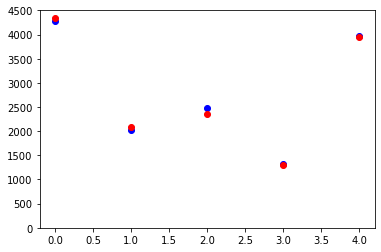

In [40]:
# update parameters and save the new models

data = np.array([4347, 2087, 2348, 1304, 3957])
preds = np.zeros(len(models_loaded))

for i, model in enumerate(models_loaded):
    basico.set_current_model(model)
    for m, param_name in enumerate(reacts_list):
        basico.set_reaction(param_name, mapping={"k1": best_fit[m]})
    tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
    print(tc["V"].loc[57000])
    preds[i] = tc["V"].loc[57000]
    new_mod = models[i].split(".")[0][0:len(models[i].split(".")[0])-1] + "3.xml"
    save_model(new_mod)
    
    
plt.scatter(range(len(preds)),preds, color = "blue")

plt.scatter(range(len(data)),data, color = "red")
plt.ylim(0,4500)